In [89]:
from collections import defaultdict
import pyzx as zx
import networkx as nx
import matplotlib.pyplot as plt

h1 = [8, 9, 10, 12, 14]
cnots = [(8, 7), (12, 11), (10, 13), (12, 13), (9, 11), (10, 7), (8, 11), (9, 10), (14, 8), (14, 10), (14, 12),
         (0, 7), (1, 8), (2, 9), (3, 10), (4, 11), (5, 12), (6, 13)]
h2 = [14]

circ = zx.Circuit(7)

for i in range(7, 15):
    if i in h1:
        circ.add_gate("InitAncilla", label=i, basis="X")
    else:
        circ.add_gate("InitAncilla", label=i, basis="Z")

for c, n in cnots:
    circ.add_gate("CNOT", c, n)

for i in range(7, 15):
    if i in h2:
        circ.add_gate("PostSelect", label=i, basis="X")
    else:
        circ.add_gate("PostSelect", label=i, basis="Z")

diagram = circ.to_graph()

zx.draw(diagram, labels=True)
for v in diagram.vertex_set():
    if diagram.vertex_degree(v) == 1 and diagram.type(v) != zx.VertexType.BOUNDARY:
        [n] = diagram.neighbors(v)
        zx.basicrules.fuse(diagram, n, v)

for v in diagram.vertex_set():
    if diagram.vertex_degree(v) == 2 and diagram.type(v) != zx.VertexType.BOUNDARY:
        zx.basicrules.remove_id(diagram, v)

zx.draw(diagram, labels=True)

paths = defaultdict(<class 'list'>, {0: [0, 38, 59], 1: [1, 40, 60], 2: [2, 42, 61], 3: [3, 44, 62], 4: [4, 46, 63], 5: [5, 48, 64], 6: [6, 50, 65], 13: [21], 12: [22, 35], 11: [23, 27], 7: [25], 10: [26, 29, 33], 8: [28, 31], 9: [30], 14: [34]})


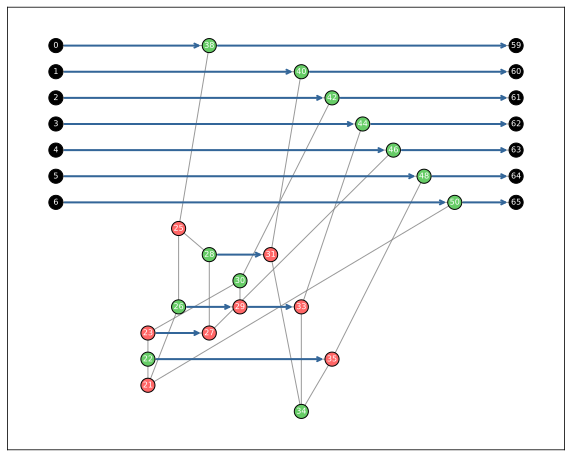

In [90]:
type_to_color = {
    zx.VertexType.Z: "#66cc66", # Lighter green
    zx.VertexType.X: "#ff6666", # Lighter red
    zx.VertexType.BOUNDARY: "black",
}

def zx_diagram_to_networkx_graph(graph):
    graph_dict = graph.to_dict()
    G = nx.Graph()
    pos = {}
    node_types = {}
    qubit_indices = {}

    for v_data in graph_dict['vertices']:
        v_id = v_data['id']
        G.add_node(v_id)

        (row, qubit) = v_data['pos']

        pos[v_id] = (row, -qubit)
        node_types[v_id] = v_data['t']
        qubit_indices[v_id] = qubit

    for u, v, _ in graph_dict['edges']:
        G.add_edge(u, v)

    return G, pos, node_types, qubit_indices

G, pos, node_types, qubit_indices = zx_diagram_to_networkx_graph(diagram)


paths = defaultdict(list)
for v in G.nodes():
    paths[qubit_indices[v]].append(v)
for path in paths.values():
    path.sort(key=lambda v: pos[v][0])

def visualize_path_cover(G, pos, node_types, paths):
    world_line_edges = []
    for q, p in paths.items():
        world_line_edges += list(zip(p, p[1:]))

    node_colors = [type_to_color[node_types[n]] for n in G.nodes()]

    # Plotting
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, edgecolors='black')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(),
                           edge_color='gray', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=world_line_edges,
                           edge_color='#336699', width=2, arrows=True, arrowstyle='->')
    nx.draw_networkx_labels(G, pos, font_color='white', font_size=8)
    plt.show()

print(f"{paths = }")
visualize_path_cover(G, pos, node_types, paths)

Is the flow causal? True


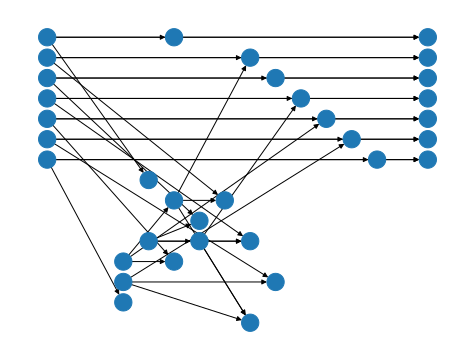

In [94]:
def check_causal_flow(G_undirected, paths_dict):
    """
    Checks if a set of directed paths on an undirected graph forms a valid
    Causal Flow.

    The condition requires that for every directed step u -> v in the paths:
    1. u must precede v (u < v).
    2. u must precede ALL neighbors of v (except u itself).
       (i.e., if v 'corrects' u, then v's interactions must happen after u).
    """
    constraint_graph = nx.DiGraph()
    constraint_graph.add_nodes_from(G_undirected.nodes())

    for path_nodes in paths_dict.values():
        for i in range(len(path_nodes) - 1):
            u = path_nodes[i]
            v = path_nodes[i+1]

            constraint_graph.add_edge(u, v)

            v_neighbors = G_undirected.neighbors(v)
            for neighbor in v_neighbors:
                if neighbor != u:
                    constraint_graph.add_edge(u, neighbor)
    nx.draw(constraint_graph, pos)

    return nx.is_directed_acyclic_graph(constraint_graph)

is_causal = check_causal_flow(G, paths)
print(f"Is the flow causal? {is_causal}")

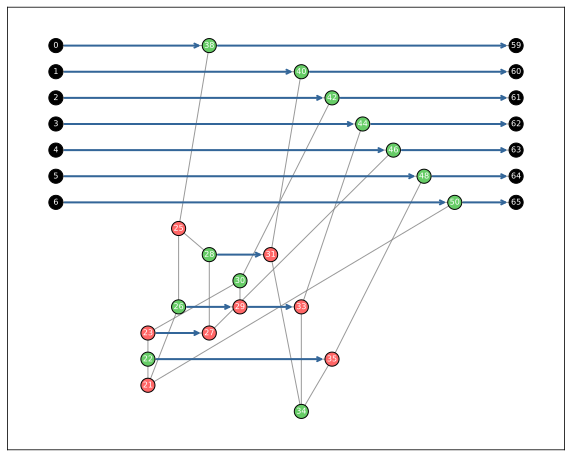

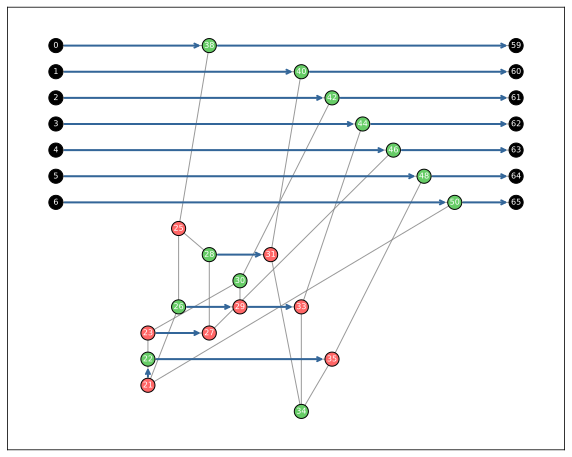

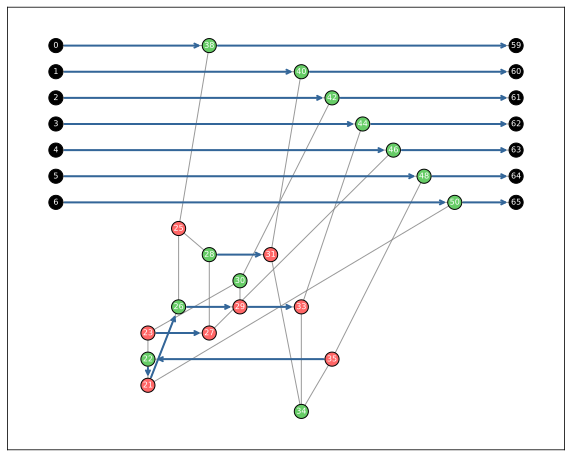

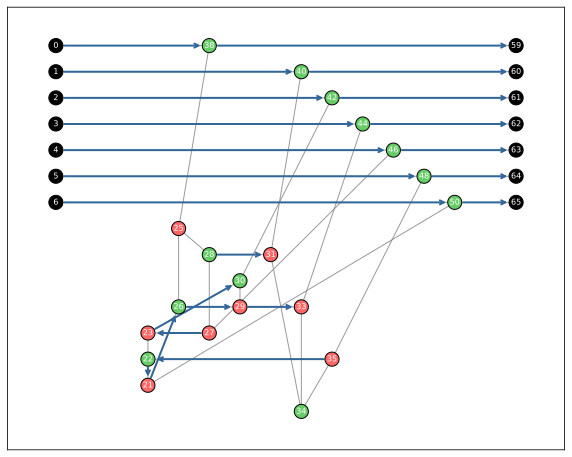

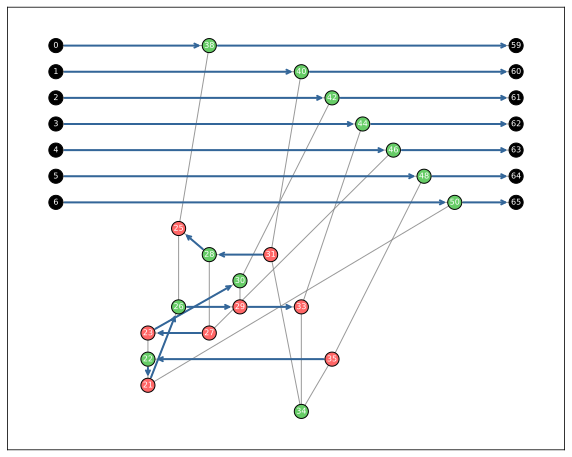

In [88]:
import copy

def bell_bends(G, paths):
    vertex_qubit = dict()
    for k, path in paths.items():
        for v in path:
            vertex_qubit[v] = k

    for v, w in G.edges():
        if paths[vertex_qubit[v]][0] == v and paths[vertex_qubit[w]][0] == w:
            yield vertex_qubit[v], vertex_qubit[w]

    # for v, w in G.edges():
    #     if paths[vertex_qubit[v]][0] == v and paths[vertex_qubit[w]][-1] == w:
    #         yield vertex_qubit[v], vertex_qubit[w]
    #     if paths[vertex_qubit[v]][-1] == v and paths[vertex_qubit[w]][0] == w:
    #         yield vertex_qubit[v], vertex_qubit[w]
    #     if paths[vertex_qubit[v]][-1] == v and paths[vertex_qubit[w]][-1] == w:
    #         yield vertex_qubit[v], vertex_qubit[w]



def try_apply_bell_bend(G, paths, i, j):
    new_paths = copy.deepcopy(paths)
    merged_path = list(reversed(paths[i])) + paths[j]
    del new_paths[j]
    new_paths[i] = merged_path

    if check_causal_flow(G, new_paths):
        return new_paths

    new_paths[i].reverse()
    if check_causal_flow(G, new_paths):
        return new_paths

    return None


def greedy_bend(G, paths):
    can_bend = True
    while can_bend:
        visualize_path_cover(G, pos, node_types, paths)
        can_bend = False
        for bend_at in bell_bends(G, paths):
            new_paths = try_apply_bell_bend(G, paths, *bend_at)
            if new_paths is not None:
                can_bend = True
                paths = new_paths
                break

greedy_bend(G, paths)

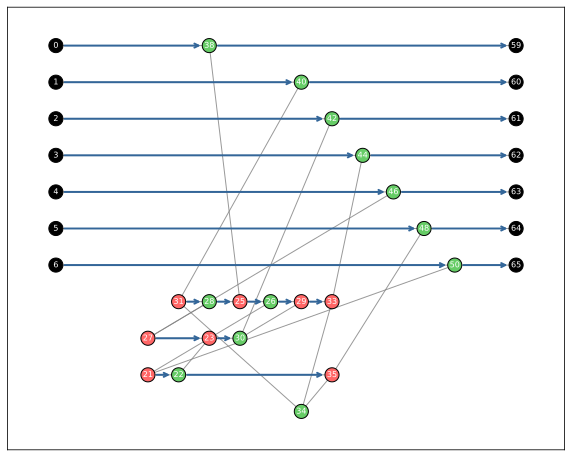

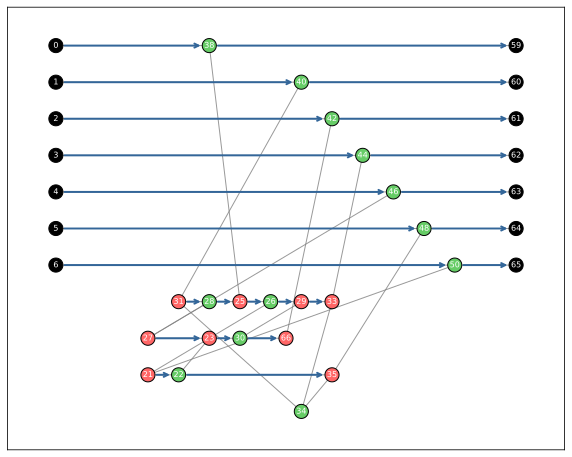

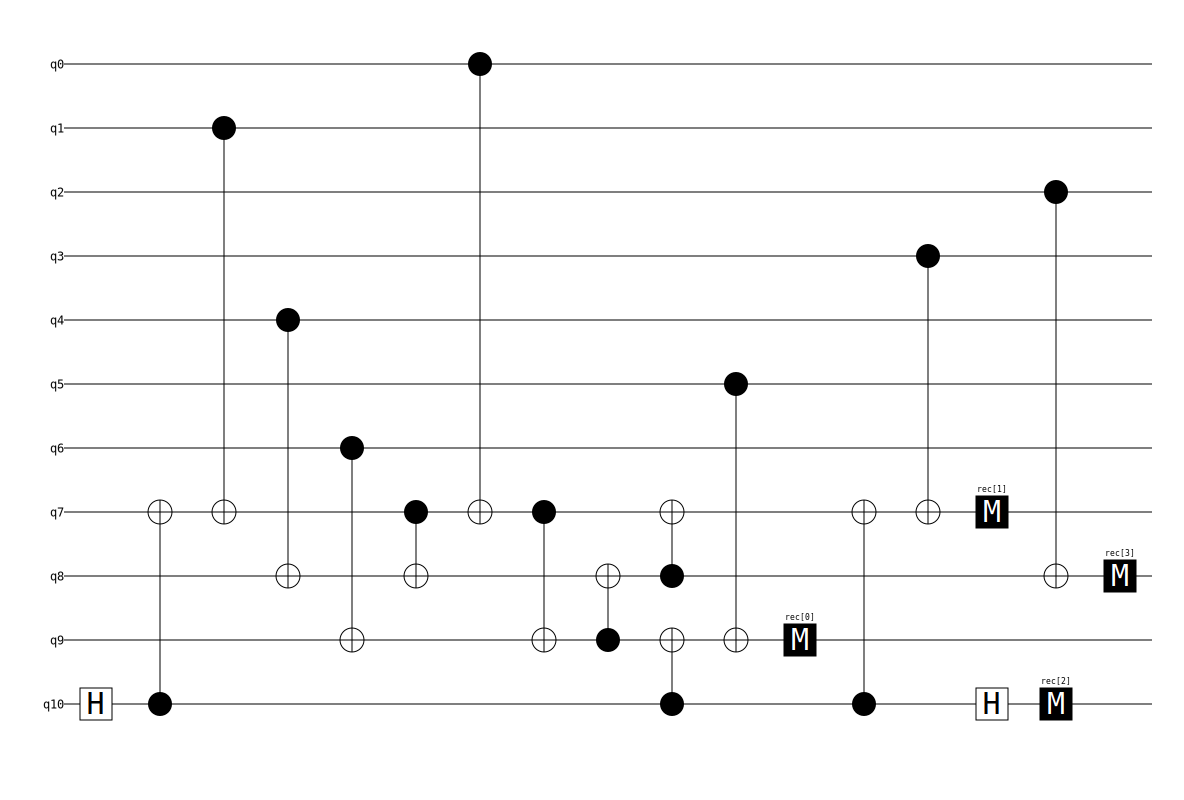

In [2]:
from path_cover_opt import *

diagram = steane_code().to_graph()
basic_FE_opt(diagram)
G, pos, node_types, qubit_indices = zx_diagram_to_networkx_graph(diagram)
paths = trivial_paths(G, qubit_indices, pos)
# visualize_path_cover(G, pos, node_types, paths)
new_paths = greedy_bend(G, paths, node_types)
realign_pos(pos, new_paths)
visualize_path_cover(G, pos, node_types, new_paths)

insert_empty_spiders(G, pos, node_types, new_paths)
realign_pos(pos, new_paths)
visualize_path_cover(G, pos, node_types, new_paths)
c = extract_circuit(G, pos, node_types, new_paths)
c.diagram('timeline-svg')